In [164]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from fbprophet import Prophet
import warnings
warnings.filterwarnings("ignore")

from fbprophet import Prophet, diagnostics
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, add_changepoints_to_plot, plot_plotly

In [165]:
c19_all_us = pd.read_csv('https://raw.githubusercontent.com/RileyWClarke/MLTSA_COVID19/master/us_covid19_daily.csv')

In [166]:
c19_all_us['date'] = pd.to_datetime(c19_all_us['date'], format='%Y%m%d')

In [167]:
c19_all_us.head()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,2020-04-30,56,1061101,5170081.0,2775.0,53793.0,111955.0,9486.0,4192.0,4712.0,...,111955.0,6233957,6231182,6231182,NaN,2041.0,2265.0,178613.0,27944.0,206557.0
1,2020-04-29,56,1033157,4991468.0,4832.0,54930.0,109690.0,9612.0,4093.0,4796.0,...,109690.0,6029457,6024625,6024625,NaN,2700.0,3382.0,203898.0,27565.0,231463.0
2,2020-04-28,56,1005592,4787570.0,4206.0,54940.0,106308.0,9491.0,3798.0,4760.0,...,106308.0,5797368,5793162,5793162,NaN,2198.0,2059.0,175209.0,24458.0,199667.0
3,2020-04-27,56,981134,4612361.0,4077.0,54971.0,104249.0,9655.0,3720.0,4867.0,...,104249.0,5597572,5593495,5593495,NaN,1163.0,3016.0,168567.0,21876.0,190443.0
4,2020-04-26,56,959258,4443794.0,4445.0,55050.0,101233.0,14831.0,2571.0,5121.0,...,101233.0,5407497,5403052,5403052,NaN,1095.0,2134.0,179387.0,27016.0,206403.0


In [168]:
c19_all_us.columns

Index(['date', 'states', 'positive', 'negative', 'pending',
       'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently',
       'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative',
       'recovered', 'hash', 'dateChecked', 'death', 'hospitalized', 'total',
       'totalTestResults', 'posNeg', 'fips', 'deathIncrease',
       'hospitalizedIncrease', 'negativeIncrease', 'positiveIncrease',
       'totalTestResultsIncrease'],
      dtype='object')

### See the confirmed and deceased cases:

(18283, 18392)

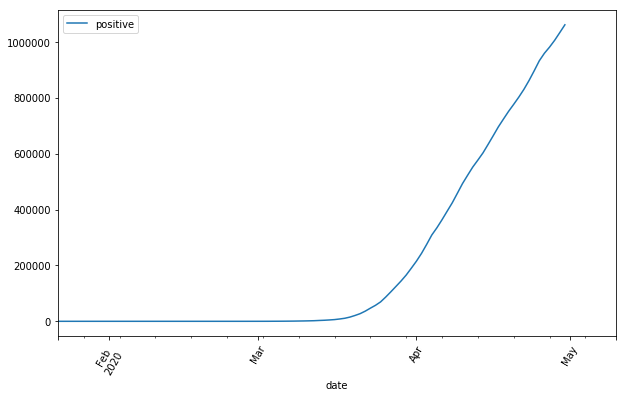

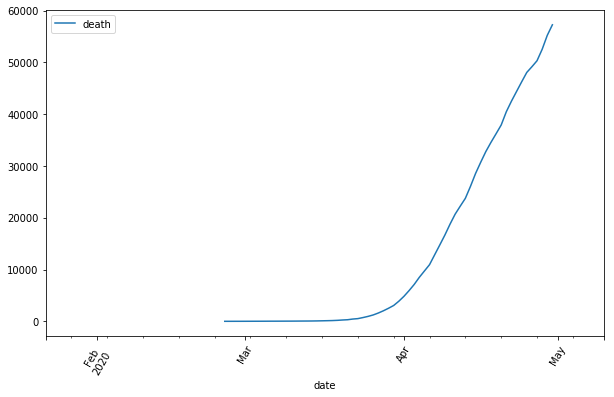

In [169]:
pd.plotting.register_matplotlib_converters()

fig,ax=plt.subplots(figsize=(10,6))
c19_all_us.plot(x='date',y='positive',rot = 60,ax=ax)
ax.set_xlim(c19_all_us['date'].iloc[-1], pd.Timestamp('2020-05-10'))

fig,ax=plt.subplots(figsize=(10,6))
c19_all_us.plot(x='date',y='death',rot = 60,ax=ax)
ax.set_xlim(c19_all_us['date'].iloc[-1], pd.Timestamp('2020-05-10'))

In [10]:
c19_all_us['date'].iloc[-1]

Timestamp('2020-01-22 00:00:00')

### Daily Increase

(18283, 18392)

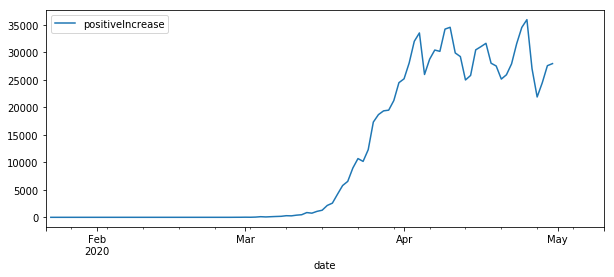

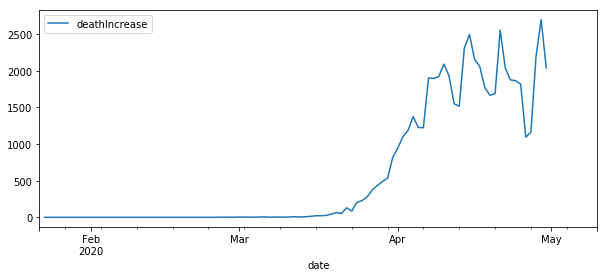

In [170]:
fig,ax=plt.subplots(figsize=(10,4))
c19_all_us.plot(x='date',y='positiveIncrease',ax=ax)
ax.set_xlim(c19_all_us['date'].iloc[-1], pd.Timestamp('2020-05-10'))

fig,ax=plt.subplots(figsize=(10,4))
c19_all_us.plot(x='date',y='deathIncrease',ax=ax)
ax.set_xlim(c19_all_us['date'].iloc[-1], pd.Timestamp('2020-05-10'))

### Step 1: Fit a logistics growth function to the data.

In [12]:
def func_logistic(t, a, b, c):
    return c / (1 + a * np.exp(-b*t))

In [13]:
from scipy.optimize import curve_fit

In [14]:
confirmed_data=c19_all_us[::-1].reset_index().rename(columns={'date':'ds','positive':'y'})
death_data = c19_all_us[::-1].reset_index().rename(columns={'date':'ds','death':'y'})


### Confirmed:

a =  39851.893180719606
b =  0.128165144121567
c =  1123427.8196598024


Text(0.5, 0, 'index')

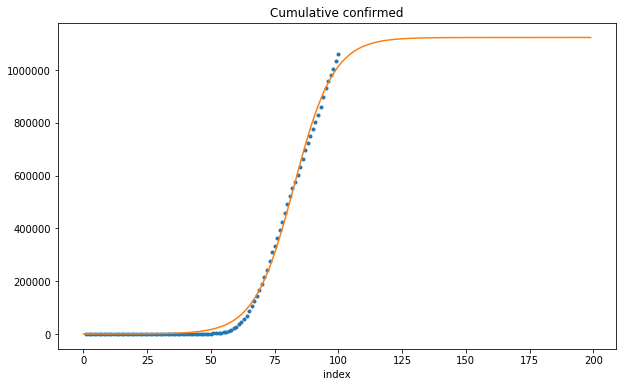

In [15]:
# Randomly initialize the coefficients
p0 = np.random.exponential(size=3)

# Set min bound 0 on all coefficients, and set different max bounds for each coefficient
bounds = (0, [1000000., 1000., 1000000000.])

# Convert pd.Series to np.Array and use Scipy's curve fit to find the best Nonlinear Least Squares coefficients
x = np.array(confirmed_data.index.values)+1
y = np.array(confirmed_data['y'])

(a,b,c),cov = curve_fit(func_logistic, 
                              x, y, bounds=bounds, p0=p0, maxfev=1000000)

print('a = ',a)
print('b = ',b)
print('c = ',c)

fig,ax=plt.subplots(figsize=(10,6))

xx=np.arange(200)
ax.plot(x, y,'.')
ax.plot(xx, func_logistic(xx, a, b, c))
ax.set_title('Cumulative confirmed')
ax.set_xlabel('index')

### The death data:

a =  471014.15960544016
b =  0.15162522601173992
c =  61235.37251772894


Text(0.5, 0, 'index')

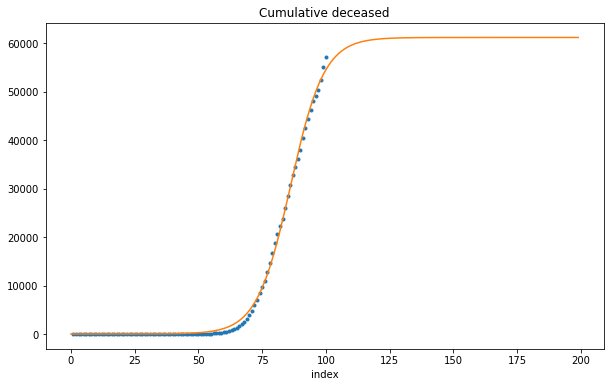

In [16]:
x = np.array(death_data.index.values)+1
y = np.nan_to_num(np.array(death_data['y']))

(a,b,c),cov = curve_fit(func_logistic, 
                              x, y, bounds=bounds, p0=p0) #, maxfev=1000000)

print('a = ',a)
print('b = ',b)
print('c = ',c)

fig,ax=plt.subplots(figsize=(10,6))

xx=np.arange(200)
ax.plot(x, y,'.')
ax.plot(xx, func_logistic(xx, a, b, c))

ax.set_title('Cumulative deceased')
ax.set_xlabel('index')

## Using Prophet

40   2020-03-02
79   2020-04-10
Name: ds, dtype: datetime64[ns]

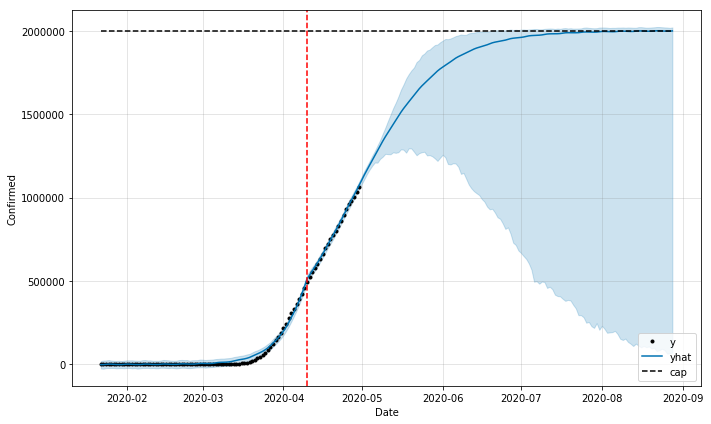

In [123]:
simlog = Prophet(growth='logistic',interval_width=0.95,n_changepoints=2,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
     
    changepoint_prior_scale=0.1) 

confirmed_train = confirmed_data
confirmed_train['cap'] = 2000000
simlog.fit(confirmed_train)
future = simlog.make_future_dataframe(periods=120)
future['cap'] = 2000000
forecast = simlog.predict(future)

fig5, ax = plt.subplots(figsize=(10,6))
simlog.plot(forecast,ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed')
#
#ax.plot(confirmed_data[-10:].ds,confirmed_data[-10:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlog, forecast,trend=False)
ax.legend()

In [124]:
simlog.changepoints

40   2020-03-02
79   2020-04-10
Name: ds, dtype: datetime64[ns]

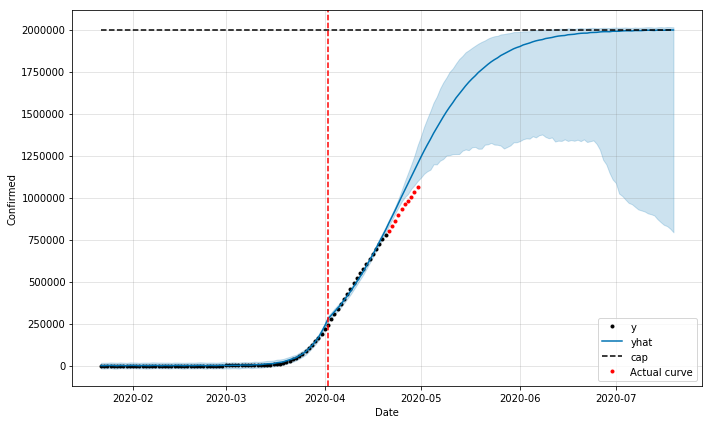

In [41]:
simlog = Prophet(growth='logistic',interval_width=0.95,n_changepoints=6,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    #changepoints = ['2020-02-27','2020-03-08','2020-04-05'],  
    changepoint_prior_scale=0.5)

confirmed_train = confirmed_data[:-10]
confirmed_train['cap'] = 2000000
simlog.fit(confirmed_train)
future = simlog.make_future_dataframe(periods=90)
future['cap'] = 2000000
forecast = simlog.predict(future)

fig5, ax = plt.subplots(figsize=(10,6))
simlog.plot(forecast,ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed')
#
ax.plot(confirmed_data[-10:].ds,confirmed_data[-10:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlog, forecast,trend=False)
ax.legend()

**Figure.** 

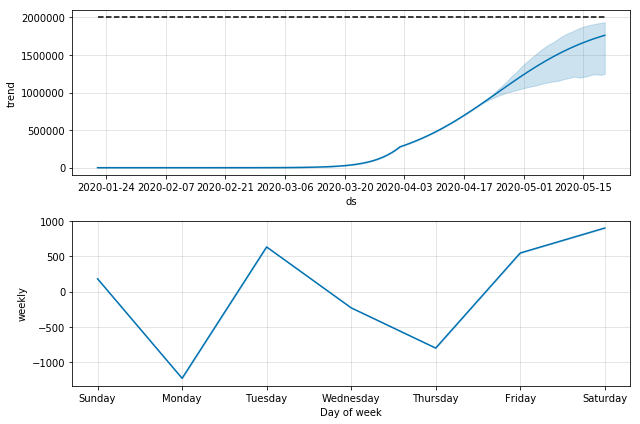

In [37]:
simlog.plot_components(forecast);

In [28]:
cvresult_simlog = cross_validation(simlog, horizon = '10 days')

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-02-25 00:00:00 and 2020-04-10 00:00:00


In [30]:
cvresult_simlog.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
95,2020-04-16,8.434453e+05,773646.804477,9.187661e+05,664129,2020-04-10
96,2020-04-17,9.040129e+05,807505.280529,9.967272e+05,695761,2020-04-10
97,2020-04-18,9.681755e+05,835798.877779,1.086259e+06,723776,2020-04-10
98,2020-04-19,1.029394e+06,872677.939135,1.166488e+06,751287,2020-04-10
99,2020-04-20,1.090277e+06,910550.792311,1.249097e+06,776419,2020-04-10


## Death data:

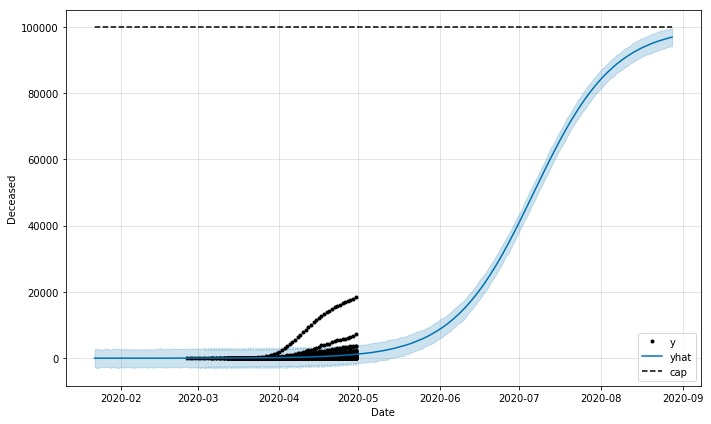

In [178]:
simlog_death = Prophet(growth='logistic',interval_width=0.95,n_changepoints=2,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
     
    changepoint_prior_scale=0.5)

death_train=death_data[:]
death_train['cap'] = 100000
simlog_death.fit(death_train)
future_death = simlog_death.make_future_dataframe(periods=120)
future_death['cap'] = 100000
forecast_death = simlog_death.predict(future_death)

fig5, ax = plt.subplots(figsize=(10,6))
simlog_death.plot(forecast_death,ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Deceased')
#
#ax.plot(death_data[-10:].ds,death_data[-10:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlog_death, forecast_death,trend=False)
ax.legend()


In [135]:
simlog_death.changepoints

22   2020-03-19
43   2020-04-09
Name: ds, dtype: datetime64[ns]

# State by state

In [180]:
#Read US states data
statedata = pd.read_csv('https://raw.githubusercontent.com/RileyWClarke/MLTSA_COVID19/master/us_states_covid19_daily.csv')

In [181]:
statedata['date'] = pd.to_datetime(statedata['date'], format='%Y%m%d')

In [182]:
statedata.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,2020-04-30,AK,355.0,18764.0,NaN,19.0,NaN,NaN,NaN,NaN,...,NaN,19119.0,19119.0,19119.0,2,0.0,0.0,0.0,0.0,0.0
1,2020-04-30,AL,7019.0,80177.0,NaN,NaN,978.0,NaN,335.0,NaN,...,978.0,87196.0,87196.0,87196.0,1,24.0,33.0,6570.0,177.0,6747.0
2,2020-04-30,AR,3255.0,45124.0,NaN,95.0,402.0,NaN,NaN,23.0,...,402.0,48379.0,48379.0,48379.0,5,2.0,13.0,2867.0,63.0,2930.0
3,2020-04-30,AS,0.0,3.0,17.0,NaN,NaN,NaN,NaN,NaN,...,NaN,20.0,3.0,3.0,60,0.0,0.0,0.0,0.0,0.0
4,2020-04-30,AZ,7648.0,64138.0,NaN,755.0,1169.0,311.0,NaN,194.0,...,1169.0,71786.0,71786.0,71786.0,4,16.0,38.0,2527.0,446.0,2973.0


In [176]:
def moving_average(a, n=8):
    #http://stackoverflow.com/questions/14313510/ddg#14314054
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [177]:
statedata.columns

Index(['date', 'state', 'positive', 'negative', 'pending',
       'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently',
       'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative',
       'recovered', 'hash', 'dateChecked', 'death', 'hospitalized', 'total',
       'totalTestResults', 'posNeg', 'fips', 'deathIncrease',
       'hospitalizedIncrease', 'negativeIncrease', 'positiveIncrease',
       'totalTestResultsIncrease'],
      dtype='object')

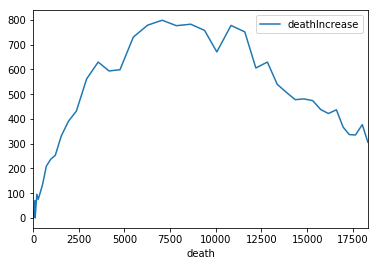

In [196]:
statedata[statedata['state']=='NY'].plot(
    x='death',y='deathIncrease')

In [248]:
statedata['state'].unique()

array(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV',
       'WY'], dtype=object)

In [179]:
#Read South Korea data
SK_data= pd.read_csv('https://raw.githubusercontent.com/RileyWClarke/MLTSA_COVID19/master/Time.csv')
SK_data['date'] = pd.to_datetime(SK_data['date'], format='%Y-%m-%d')

In [33]:
SK_deaths = SK_data.reset_index().rename(columns={'date':'ds','deceased':'y'})

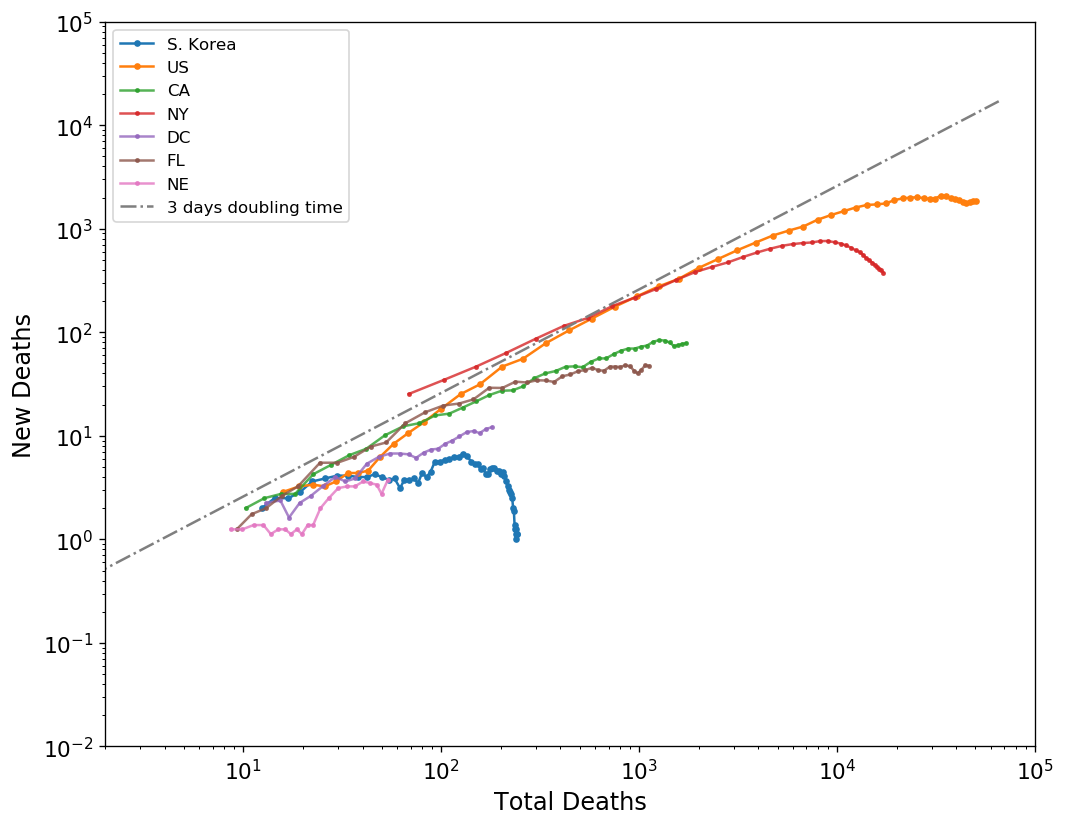

In [46]:
fig,ax = plt.subplots(1,1,figsize=(10,8),dpi=120)

state_list = ['CA', 'NY', 'DC','FL','NE']

x_values = SK_deaths.y[SK_deaths.y >3].values
x_values = moving_average(x_values)
ax.plot(x_values[:-1],np.diff(x_values),'-o',label='S. Korea',markersize=3)

x_values = c19_all_us.death[c19_all_us.death>3].values
x_values = moving_average(x_values)
ax.plot(x_values[:-1],-1*np.diff(x_values),'-o',label='US',markersize=3)

for st in state_list:
    
    death_st = statedata[statedata['state']==st].death
    #
    x_values = death_st[death_st >3].values
    x_values = moving_average(x_values)
    ax.plot(x_values[:-1],-1*np.diff(x_values),'-o',label=st,markersize=2,alpha = 0.8)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(.01,1e5)
ax.set_xlim(2,1e5)
ax.set_xlabel('Total Deaths',fontsize='x-large')
ax.set_ylabel('New Deaths',fontsize='x-large')
ax.tick_params(axis='both', which='major', labelsize=13)


T = 50
tt = np.linspace(1, T,T)

xx = 2**((tt-1)/3 )
dxdt = np.diff(xx)

ax.plot(xx[:-1], dxdt, '-.',label='3 days doubling time')


# T = 100
# tt = np.linspace(1, T,T)

# xx = 2**((tt-1)/7 )
# dxdt = np.diff(xx)

# #ax.plot(xx[:-1], dxdt, '-.',c='k',label='7 days doubling time')

ax.legend()

In [183]:
death_st[death_st >3].reset_index().index.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

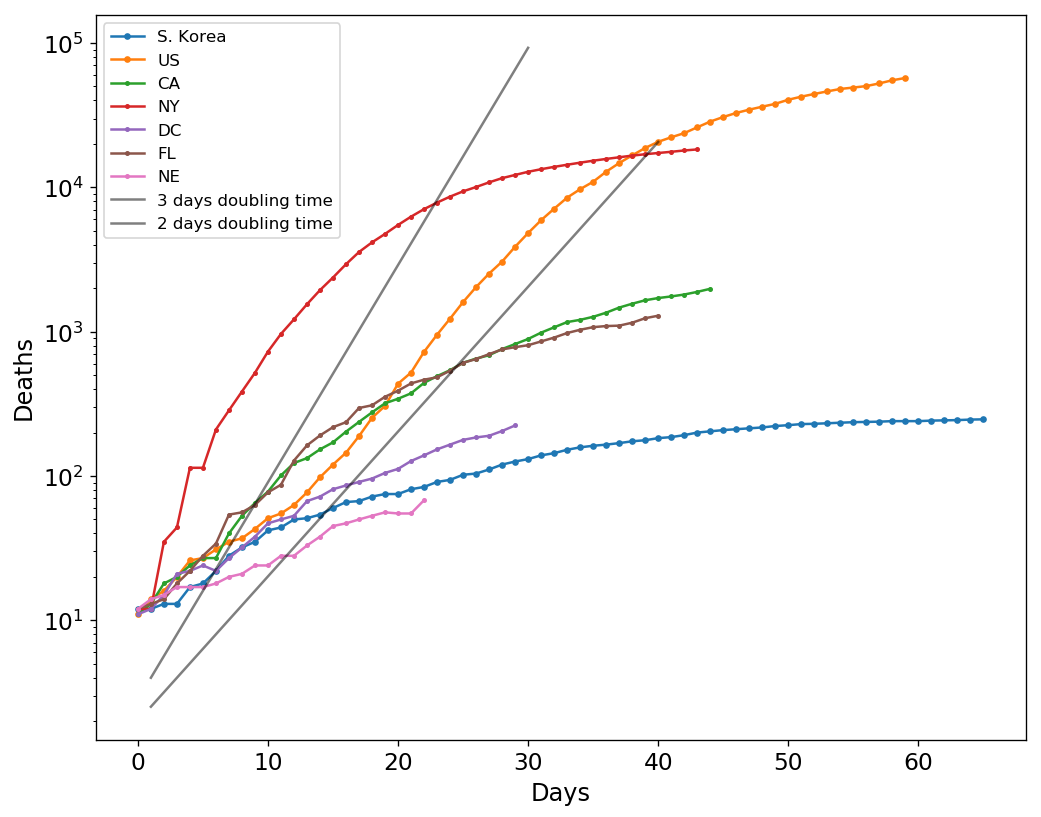

In [468]:
fig,ax = plt.subplots(1,1,figsize=(10,8),dpi=120)

state_list = ['CA', 'NY', 'DC','FL','NE']

N = 10
ind = SK_deaths[SK_deaths.y >N].index
ind = ind-ind[0]
x_values = SK_deaths[SK_deaths.y >N].y
ax.plot(ind,x_values,'-o',label='S. Korea',markersize=3)

ind = c19_all_us.death[c19_all_us.death>N].reset_index().index.values
ind = ind-ind[0]
x_values = c19_all_us.death[c19_all_us.death>N].values
ax.plot(ind,x_values[::-1],'-o',label='US',markersize=3)

for st in state_list:
    
    death_st = statedata[statedata['state']==st].death
    
    ind = death_st[death_st >N].reset_index().index.values
    ind = ind-ind[0]
    x_values = death_st[death_st >N].values
    ax.plot(ind,x_values[::-1],'-o',label=st,markersize=2)

#ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim(.01,1e5)
#ax.set_xlim(2,1e5)
ax.set_xlabel('Days',fontsize='x-large')
ax.set_ylabel('Deaths',fontsize='x-large')
ax.tick_params(axis='both', which='major', labelsize=14)


T = 40
tt = np.linspace(1, T,T)

xx = 2**((tt+3)/3 ) 
dxdt = np.diff(xx)

ax.plot(tt, xx, label='3 days doubling time', c='k',alpha =0.5)


T = 30
tt = np.linspace(1, T,T)

xx = 2**((tt+3)/2 ) 
dxdt = np.diff(xx)

ax.plot(tt, xx, label='2 days doubling time',c='k',alpha =0.5)

ax.legend()

In [352]:
def rollingpower(x, N,a1,a2):
   
    return 10**(a1*(x-N)+ a2*(x-N)**2)

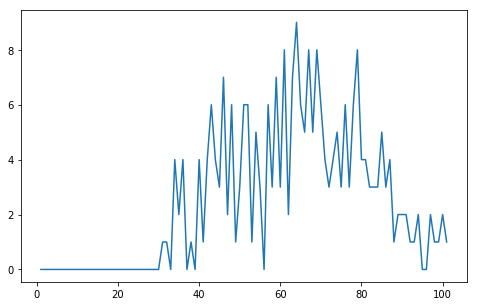

In [349]:
T = len(SK_data)
tt = np.linspace(1,T,T)

fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(tt[:-1], np.diff(SK_data.deceased))


In [460]:
statedata.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,2020-04-30,AK,355.0,18764.0,NaN,19.0,NaN,NaN,NaN,NaN,...,NaN,19119.0,19119.0,19119.0,2,0.0,0.0,0.0,0.0,0.0
1,2020-04-30,AL,7019.0,80177.0,NaN,NaN,978.0,NaN,335.0,NaN,...,978.0,87196.0,87196.0,87196.0,1,24.0,33.0,6570.0,177.0,6747.0
2,2020-04-30,AR,3255.0,45124.0,NaN,95.0,402.0,NaN,NaN,23.0,...,402.0,48379.0,48379.0,48379.0,5,2.0,13.0,2867.0,63.0,2930.0
3,2020-04-30,AS,0.0,3.0,17.0,NaN,NaN,NaN,NaN,NaN,...,NaN,20.0,3.0,3.0,60,0.0,0.0,0.0,0.0,0.0
4,2020-04-30,AZ,7648.0,64138.0,NaN,755.0,1169.0,311.0,NaN,194.0,...,1169.0,71786.0,71786.0,71786.0,4,16.0,38.0,2527.0,446.0,2973.0


In [184]:
state_list = ['CA', 'NY', 'DC','FL','NE']

for st in state_list:
    
    death_st = statedata[statedata['state']==st].death

INFO:fbprophet:Making 2 forecasts with cutoffs between 2020-04-15 00:00:00 and 2020-04-20 00:00:00


  horizon           mse        rmse         mae      mape  coverage
0  1 days    755.689007   27.489798   22.165071  0.018469       0.5
1  2 days   1210.041336   34.785648   30.756671  0.024722       0.5
2  3 days    529.220643   23.004796   22.490509  0.017535       1.0
3  4 days   1038.482881   32.225500   32.211817  0.024022       1.0
4  5 days   1100.503330   33.173835   23.668532  0.014383       1.0
5  6 days   4264.468286   65.302896   58.188795  0.036938       1.0
6  7 days   8866.928115   94.164368   81.937138  0.049686       1.0
7  8 days  16147.404290  127.072437   98.823408  0.055840       1.0
8  9 days  21455.297442  146.476269  114.991064  0.062276       1.0
9 10 days  23564.493939  153.507309  127.069971  0.066183       1.0


Text(0, 0.5, 'MAPE')

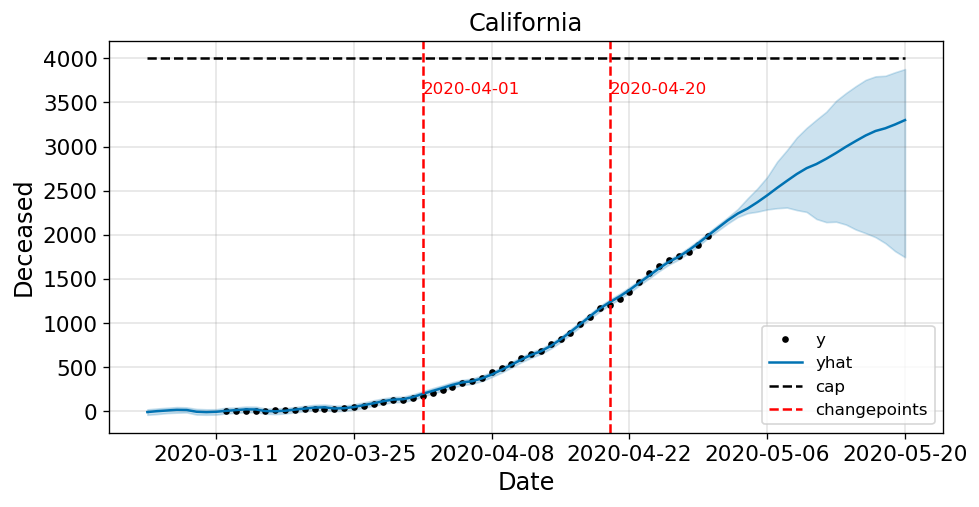

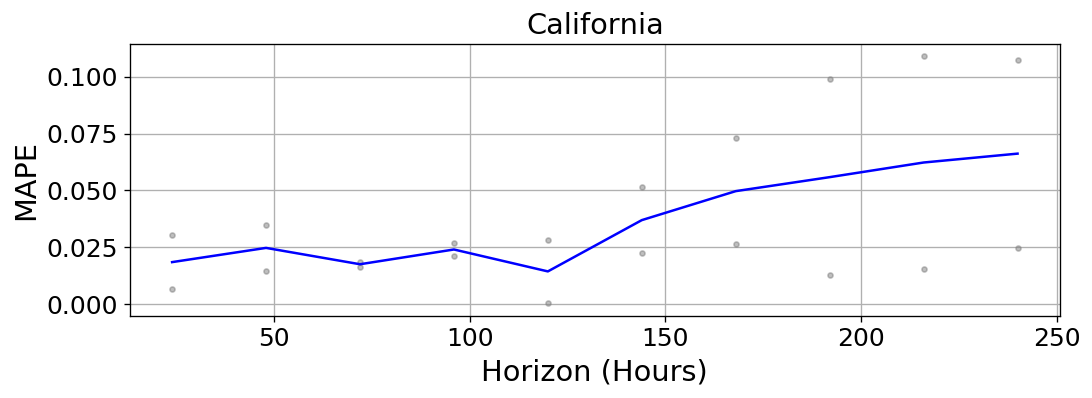

In [161]:
death_data = statedata[::-1].reset_index().rename(columns={'date':'ds','death':'y'})
CA_death = death_data[death_data['state']=='CA']

simlog_death = Prophet(growth='logistic',interval_width=0.95,n_changepoints=2,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
     
    changepoint_prior_scale=0.5)

death_train=CA_death
death_train['cap'] = 4000
simlog_death.fit(death_train)
future_death = simlog_death.make_future_dataframe(periods=20)
future_death['cap'] = 4000
forecast_death = simlog_death.predict(future_death)

fig5, ax = plt.subplots(figsize=(8,4),dpi=120)
simlog_death.plot(forecast_death,ax=ax)
ax.set_xlabel('Date',fontsize='x-large')
ax.set_ylabel('Deceased',fontsize='x-large')
ax.tick_params(axis='both', which='major', labelsize=13)
#
#ax.plot(death_data[-10:].ds,death_data[-10:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlog_death, forecast_death,trend=False)
a5[0].set_label('changepoints')
ax.text(x= simlog_death.changepoints.iloc[0], y =death_train['cap'].values[0]-0.1*death_train['cap'].values[0] ,s =simlog_death.changepoints.iloc[0].date(),color='red')#,horizontalalignment='center'
ax.text(x= simlog_death.changepoints.iloc[1], y = death_train['cap'].values[0]-0.1*death_train['cap'].values[0],s =simlog_death.changepoints.iloc[1].date(),color='red')

ax.legend()
ax.set_title('California',fontsize='x-large')

cvresult_simlog = cross_validation(simlog_death, horizon = '10 days')
print(performance_metrics(cvresult_simlog))
fig6, ax2 = plt.subplots(figsize=(10,3),dpi=120)
plot_cross_validation_metric(cvresult_simlog, metric='mape',ax = ax2);
ax2.set_title('California',fontsize='xx-large')
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlabel('Horizon (Hours)',fontsize='xx-large')
ax2.set_ylabel('MAPE',fontsize='xx-large')

In [93]:
simlog_death.changepoints

20   2020-04-01
39   2020-04-20
Name: ds, dtype: datetime64[ns]

a =  576.9541882487001
b =  0.13208818692628593
c =  2478.454071894014


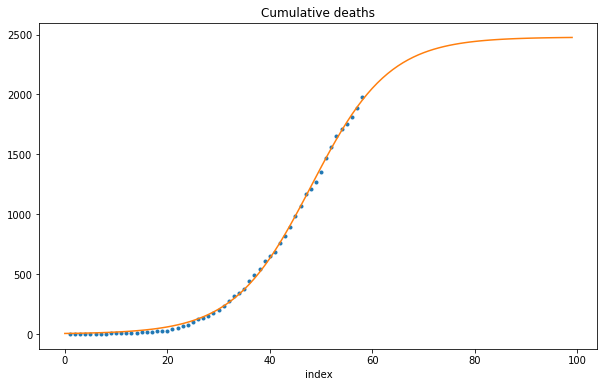

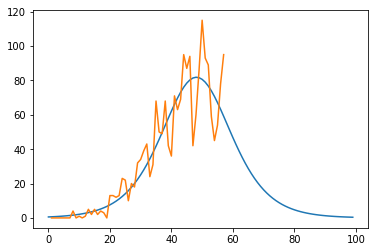

In [563]:
death_data = statedata[::-1].reset_index().rename(columns={'date':'ds','death':'y'})
deaths = death_data[death_data['state']=='CA']

# Randomly initialize the coefficients
p0 = np.random.exponential(size=3)

# Set min bound 0 on all coefficients, and set different max bounds # for each coefficient
bounds = (0, [100000., 1000., 1000000000.])

# Convert pd.Series to np.Array and use Scipy's curve fit to find   # the best Nonlinear Least Squares coefficients
x = np.array(deaths[0:].reset_index().index.values)+1
y = np.nan_to_num(np.array(deaths[0:]['y']))

(a,b,c),cov = curve_fit(func_logistic, 
                              x, y, bounds=bounds, p0=p0, maxfev=1000000)

print('a = ',a)
print('b = ',b)
print('c = ',c)





fig,ax=plt.subplots(figsize=(10,6))

xx=np.arange(100)
ax.plot(x, y,'.')
ax.plot(xx, func_logistic(xx, a, b, c))
ax.set_title('Cumulative deaths')
ax.set_xlabel('index')



def d_logistic(x,a,b,c):
    h = 1e-5
    return (func_logistic(x+h,a,b,c)-func_logistic(x-h,a,b,c))/(2*h)

plt.figure()
plt.plot(xx,d_logistic(xx,a,b,c))
plt.plot(x[:-1],np.diff(y))

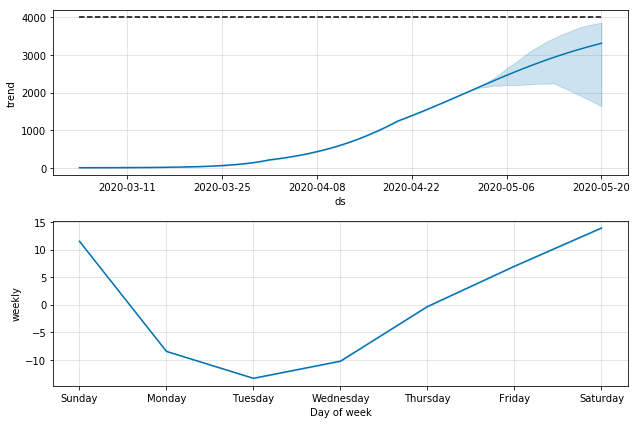

In [472]:
simlog_death.plot_components(forecast_death);

INFO:fbprophet:Making 2 forecasts with cutoffs between 2020-04-15 00:00:00 and 2020-04-20 00:00:00


  horizon           mse         rmse          mae      mape  coverage
0  1 days  7.419491e+04   272.387420   272.386648  0.020351       0.5
1  2 days  2.061621e+05   454.050743   452.077598  0.032668       0.5
2  3 days  4.593272e+05   677.736817   663.116044  0.046670       0.5
3  4 days  7.862786e+05   886.723502   859.216612  0.058678       1.0
4  5 days  1.110369e+06  1053.740628  1007.241741  0.066907       1.0
5  6 days  1.532975e+06  1238.133766  1171.987271  0.075755       1.0
6  7 days  1.987129e+06  1409.655613  1340.663232  0.084194       1.0
7  8 days  2.747070e+06  1657.428738  1587.260675  0.097048       1.0
8  9 days  3.450251e+06  1857.485085  1771.899151  0.105769       1.0
9 10 days  4.107086e+06  2026.594744  1932.497582  0.112679       1.0


Text(0, 0.5, 'MAPE')

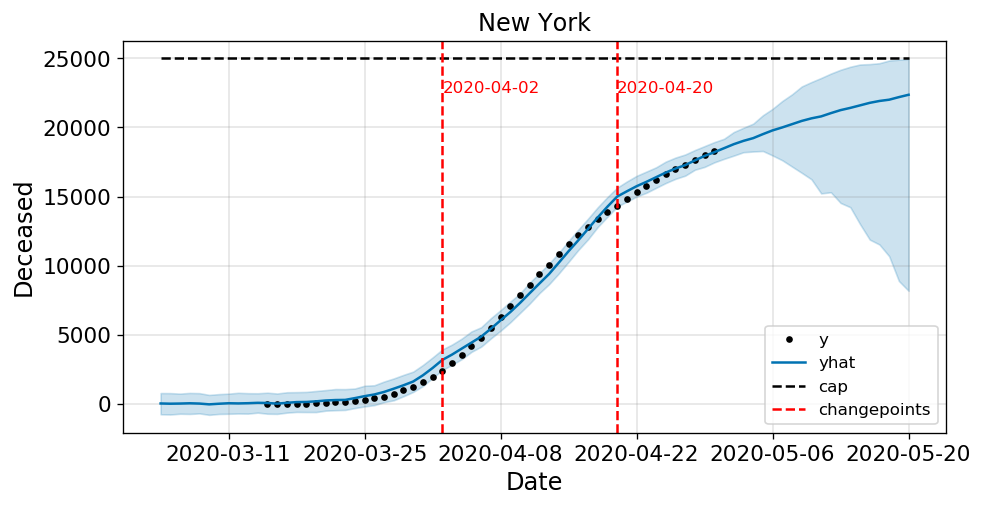

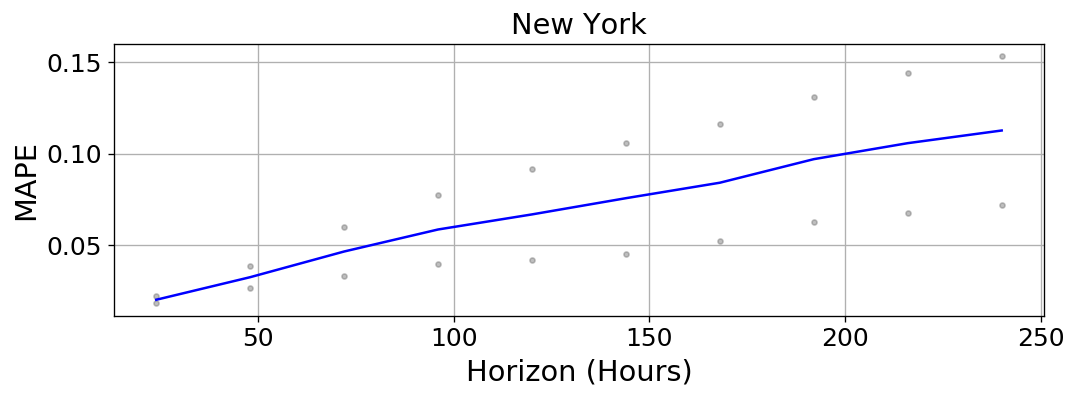

In [160]:
death_data = statedata[::-1].reset_index().rename(columns={'date':'ds','death':'y'})
CA_death = death_data[death_data['state']=='NY']

simlog_death = Prophet(growth='logistic',interval_width=0.95,n_changepoints=2,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
     
    changepoint_prior_scale=0.5)

death_train=CA_death
death_train['cap'] = 25000
simlog_death.fit(death_train)
future_death = simlog_death.make_future_dataframe(periods=20)
future_death['cap'] = 25000
forecast_death = simlog_death.predict(future_death)

fig5, ax = plt.subplots(figsize=(8,4),dpi=120)
simlog_death.plot(forecast_death,ax=ax)
ax.set_xlabel('Date',fontsize='x-large')
ax.set_ylabel('Deceased',fontsize='x-large')
ax.tick_params(axis='both', which='major', labelsize=13)
#
#ax.plot(death_data[-10:].ds,death_data[-10:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlog_death, forecast_death,trend=False)
a5[0].set_label('changepoints')
ax.legend()
ax.set_title('New York',fontsize='x-large')

a5[0].set_label('changepoints')
ax.text(x= simlog_death.changepoints.iloc[0], y =death_train['cap'].values[0]-0.1*death_train['cap'].values[0] ,s =simlog_death.changepoints.iloc[0].date(),color='red')#,horizontalalignment='center'
ax.text(x= simlog_death.changepoints.iloc[1], y = death_train['cap'].values[0]-0.1*death_train['cap'].values[0],s =simlog_death.changepoints.iloc[1].date(),color='red')


cvresult_simlog = cross_validation(simlog_death, horizon = '10 days')
print(performance_metrics(cvresult_simlog))
fig6, ax2 = plt.subplots(figsize=(10,3),dpi=120)
plot_cross_validation_metric(cvresult_simlog, metric='mape',ax = ax2);
ax2.set_title('New York',fontsize='xx-large')
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlabel('Horizon (Hours)',fontsize='xx-large')
ax2.set_ylabel('MAPE',fontsize='xx-large')

In [539]:
cvresult_simlog = cross_validation(simlog_death, horizon = '2 days')

INFO:fbprophet:Making 34 forecasts with cutoffs between 2020-03-26 00:00:00 and 2020-04-28 00:00:00


In [95]:
simlog_death.changepoints

18   2020-04-02
36   2020-04-20
Name: ds, dtype: datetime64[ns]

INFO:fbprophet:Making 2 forecasts with cutoffs between 2020-04-18 00:00:00 and 2020-04-20 00:00:00


  horizon         mse       rmse        mae      mape  coverage
0  1 days   50.846588   7.130679   6.581400  0.065701       0.5
1  2 days   61.925130   7.869252   6.312593  0.058789       0.5
2  3 days  128.456048  11.333845   9.479346  0.081804       0.5
3  4 days  104.365655  10.215951   9.732501  0.072200       0.5
4  5 days  120.386930  10.972098  10.314587  0.070480       0.5
5  6 days  140.162529  11.839026  11.651669  0.071770       0.5
6  7 days  155.412805  12.466467  10.818759  0.064053       1.0
7  8 days  197.819878  14.064845  11.635809  0.064707       1.0
8  9 days  410.444331  20.259426  15.258980  0.081972       0.5
9 10 days  820.366049  28.642033  21.800977  0.113454       0.5


Text(0, 0.5, 'MAPE')

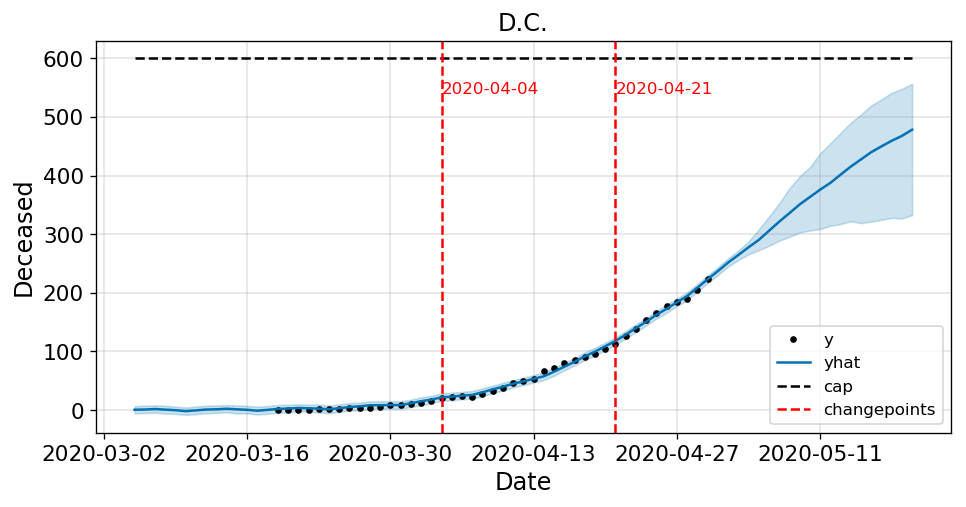

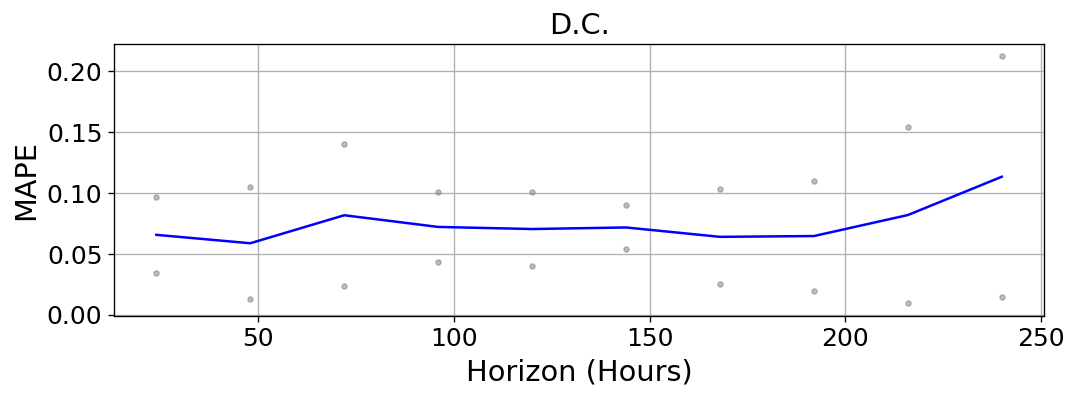

In [162]:
death_data = statedata[::-1].reset_index().rename(columns={'date':'ds','death':'y'})
CA_death = death_data[death_data['state']=='DC']

simlog_death = Prophet(growth='logistic',interval_width=0.95,n_changepoints=2,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
     
    changepoint_prior_scale=0.5)

death_train=CA_death
death_train['cap'] = 600
simlog_death.fit(death_train)
future_death = simlog_death.make_future_dataframe(periods=20)
future_death['cap'] = 600
forecast_death = simlog_death.predict(future_death)

fig5, ax = plt.subplots(figsize=(8,4),dpi=120)
simlog_death.plot(forecast_death,ax=ax)
ax.set_xlabel('Date',fontsize='x-large')
ax.set_ylabel('Deceased',fontsize='x-large')
ax.tick_params(axis='both', which='major', labelsize=13)
#
#ax.plot(death_data[-10:].ds,death_data[-10:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlog_death, forecast_death,trend=False)
a5[0].set_label('changepoints')
ax.text(x= simlog_death.changepoints.iloc[0], y =death_train['cap'].values[0]-0.1*death_train['cap'].values[0] ,s =simlog_death.changepoints.iloc[0].date(),color='red')#,horizontalalignment='center'
ax.text(x= simlog_death.changepoints.iloc[1], y = death_train['cap'].values[0]-0.1*death_train['cap'].values[0],s =simlog_death.changepoints.iloc[1].date(),color='red')

ax.legend()
ax.set_title('D.C.',fontsize='x-large')


cvresult_simlog = cross_validation(simlog_death, horizon = '10 days',period = '2 days')
print(performance_metrics(cvresult_simlog))
fig6, ax2 = plt.subplots(figsize=(10,3),dpi=120)
plot_cross_validation_metric(cvresult_simlog, metric='mape',ax = ax2);
ax2.set_title('D.C.',fontsize='xx-large')
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlabel('Horizon (Hours)',fontsize='xx-large')
ax2.set_ylabel('MAPE',fontsize='xx-large')

In [97]:
simlog_death.changepoints

16   2020-04-04
33   2020-04-21
Name: ds, dtype: datetime64[ns]

a =  1111.9746680659262
b =  0.13384400781546746
c =  334.99788997898037


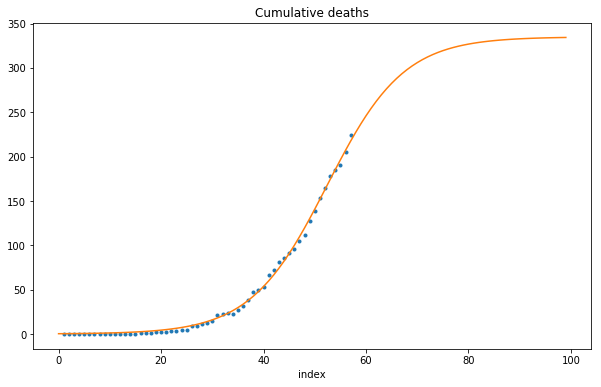

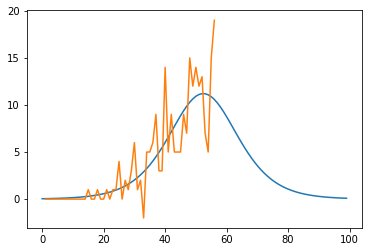

In [562]:
death_data = statedata[::-1].reset_index().rename(columns={'date':'ds','death':'y'})
deaths = death_data[death_data['state']=='DC']

# Randomly initialize the coefficients
p0 = np.random.exponential(size=3)

# Set min bound 0 on all coefficients, and set different max bounds # for each coefficient
bounds = (0, [100000., 1000., 1000000000.])

# Convert pd.Series to np.Array and use Scipy's curve fit to find   # the best Nonlinear Least Squares coefficients
x = np.array(deaths[0:].reset_index().index.values)+1
y = np.nan_to_num(np.array(deaths[0:]['y']))

(a,b,c),cov = curve_fit(func_logistic, 
                              x, y, bounds=bounds, p0=p0, maxfev=1000000)

print('a = ',a)
print('b = ',b)
print('c = ',c)





fig,ax=plt.subplots(figsize=(10,6))

xx=np.arange(100)
ax.plot(x, y,'.')
ax.plot(xx, func_logistic(xx, a, b, c))
ax.set_title('Cumulative deaths')
ax.set_xlabel('index')



def d_logistic(x,a,b,c):
    h = 1e-5
    return (func_logistic(x+h,a,b,c)-func_logistic(x-h,a,b,c))/(2*h)

plt.figure()
plt.plot(xx,d_logistic(xx,a,b,c))
plt.plot(x[:-1],np.diff(y))

INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-04-10 00:00:00 and 2020-04-20 00:00:00


  horizon           mse        rmse         mae      mape  coverage
0  1 days    424.729855   20.608975   17.109056  0.026939  0.333333
1  2 days    984.033743   31.369312   26.825040  0.045685  0.333333
2  3 days   2447.916631   49.476425   37.890747  0.068653  0.666667
3  4 days   4096.797224   64.006228   54.838643  0.087063  0.666667
4  5 days   4784.631868   69.171033   66.130730  0.089940  1.000000
5  6 days  10228.029277  101.133720   97.424463  0.124463  1.000000
6  7 days  16180.991992  127.204528  123.799088  0.146397  1.000000
7  8 days  22124.441590  148.742871  142.298454  0.158364  1.000000
8  9 days  30002.232450  173.211525  158.889698  0.174647  1.000000
9 10 days  44918.742051  211.940421  192.863893  0.205855  1.000000


Text(0, 0.5, 'MAPE')

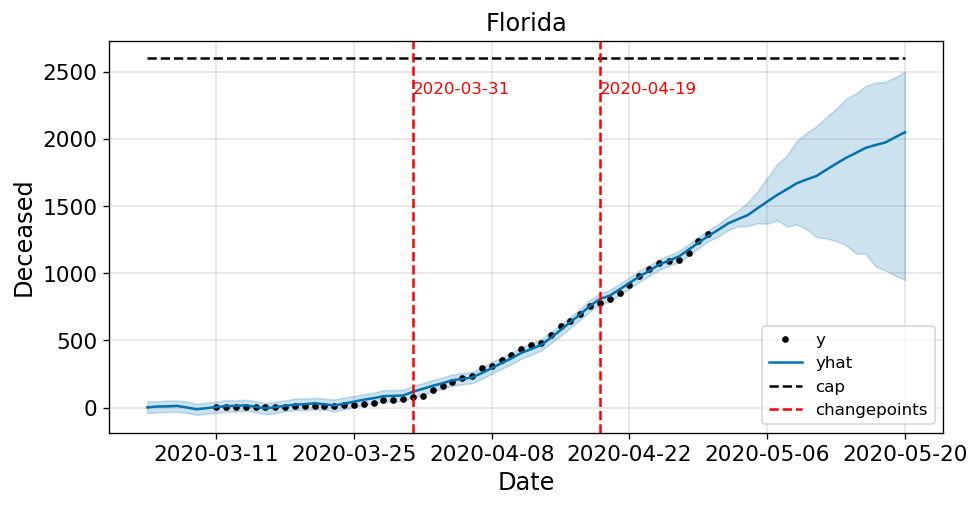

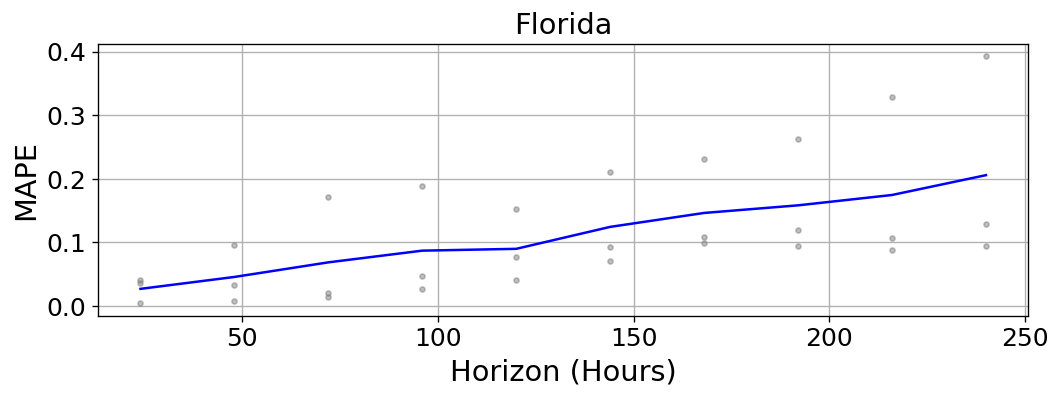

In [163]:
death_data = statedata[::-1].reset_index().rename(columns={'date':'ds','death':'y'})
CA_death = death_data[death_data['state']=='FL']

simlog_death = Prophet(growth='logistic',interval_width=0.95,n_changepoints=2,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    #changepoints=['2020-04-01','2020-04-21'], 
    changepoint_prior_scale=0.5)

death_train=CA_death
death_train['cap'] = 2600
simlog_death.fit(death_train)
future_death = simlog_death.make_future_dataframe(periods=20)
future_death['cap'] = 2600
forecast_death = simlog_death.predict(future_death)

fig5, ax = plt.subplots(figsize=(8,4),dpi=120)
simlog_death.plot(forecast_death,ax=ax)
ax.set_xlabel('Date',fontsize='x-large')
ax.set_ylabel('Deceased',fontsize='x-large')
ax.tick_params(axis='both', which='major', labelsize=13)
#
#ax.plot(death_data[-10:].ds,death_data[-10:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlog_death, forecast_death,trend=False)

a5[0].set_label('changepoints')
ax.text(x= simlog_death.changepoints.iloc[0], y =death_train['cap'].values[0]-0.1*death_train['cap'].values[0] ,s =simlog_death.changepoints.iloc[0].date(),color='red')#,horizontalalignment='center'
ax.text(x= simlog_death.changepoints.iloc[1], y = death_train['cap'].values[0]-0.1*death_train['cap'].values[0],s =simlog_death.changepoints.iloc[1].date(),color='red')


ax.legend()
ax.set_title('Florida',fontsize='x-large')


cvresult_simlog = cross_validation(simlog_death, horizon = '10 days')
print(performance_metrics(cvresult_simlog))
fig6, ax2 = plt.subplots(figsize=(10,3),dpi=120)
plot_cross_validation_metric(cvresult_simlog, metric='mape',ax = ax2);
ax2.set_title('Florida',fontsize='xx-large')
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlabel('Horizon (Hours)',fontsize='xx-large')
ax2.set_ylabel('MAPE',fontsize='xx-large')



In [104]:
simlog_death.changepoints

20   2020-03-31
39   2020-04-19
Name: ds, dtype: datetime64[ns]

a =  680.5252835319864
b =  0.1431827972531403
c =  1437.0791111137491


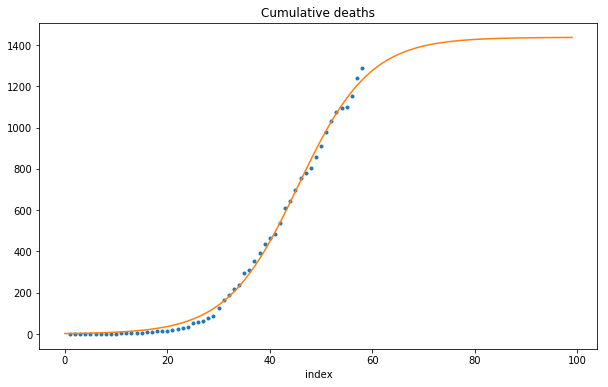

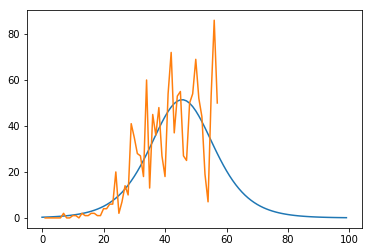

In [561]:
death_data = statedata[::-1].reset_index().rename(columns={'date':'ds','death':'y'})
deaths = death_data[death_data['state']=='FL']

# Randomly initialize the coefficients
p0 = np.random.exponential(size=3)

# Set min bound 0 on all coefficients, and set different max bounds # for each coefficient
bounds = (0, [100000., 1000., 1000000000.])

# Convert pd.Series to np.Array and use Scipy's curve fit to find   # the best Nonlinear Least Squares coefficients
x = np.array(deaths[0:].reset_index().index.values)+1
y = np.nan_to_num(np.array(deaths[0:]['y']))

(a,b,c),cov = curve_fit(func_logistic, 
                              x, y, bounds=bounds, p0=p0, maxfev=1000000)

print('a = ',a)
print('b = ',b)
print('c = ',c)





fig,ax=plt.subplots(figsize=(10,6))

xx=np.arange(100)
ax.plot(x, y,'.')
ax.plot(xx, func_logistic(xx, a, b, c))
ax.set_title('Cumulative deaths')
ax.set_xlabel('index')



def d_logistic(x,a,b,c):
    h = 1e-5
    return (func_logistic(x+h,a,b,c)-func_logistic(x-h,a,b,c))/(2*h)

plt.figure()
plt.plot(xx,d_logistic(xx,a,b,c))
plt.plot(x[:-1],np.diff(y))

In [58]:
simlog_death.changepoints

DatetimeIndex(['2020-04-01', '2020-04-21'], dtype='datetime64[ns]', freq=None)

In [134]:
pd.Timestamp.date

<method 'time' of 'datetime.datetime' objects>

In [139]:
print(simlog_death.changepoints.iloc[0].date())

2020-04-04


INFO:fbprophet:Making 2 forecasts with cutoffs between 2020-04-18 00:00:00 and 2020-04-20 00:00:00


  horizon         mse       rmse        mae      mape  coverage
0  1 days   10.245488   3.200857   3.189363  0.104543       0.0
1  2 days   22.076106   4.698522   4.275196  0.123436       0.0
2  3 days   81.265730   9.014751   8.571404  0.213826       0.0
3  4 days  102.852350  10.141615  10.077630  0.236943       0.0
4  5 days  180.001967  13.416481  13.371128  0.283504       0.0
5  6 days  192.965913  13.891217  13.860294  0.279323       0.5
6  7 days  243.350403  15.599692  15.581108  0.295744       1.0
7  8 days  225.090042  15.003001  14.656081  0.272602       1.0
8  9 days  236.001507  15.362341  14.304218  0.256845       1.0
9 10 days  331.463915  18.206150  18.168307  0.296718       1.0


Text(0, 0.5, 'MAPE')

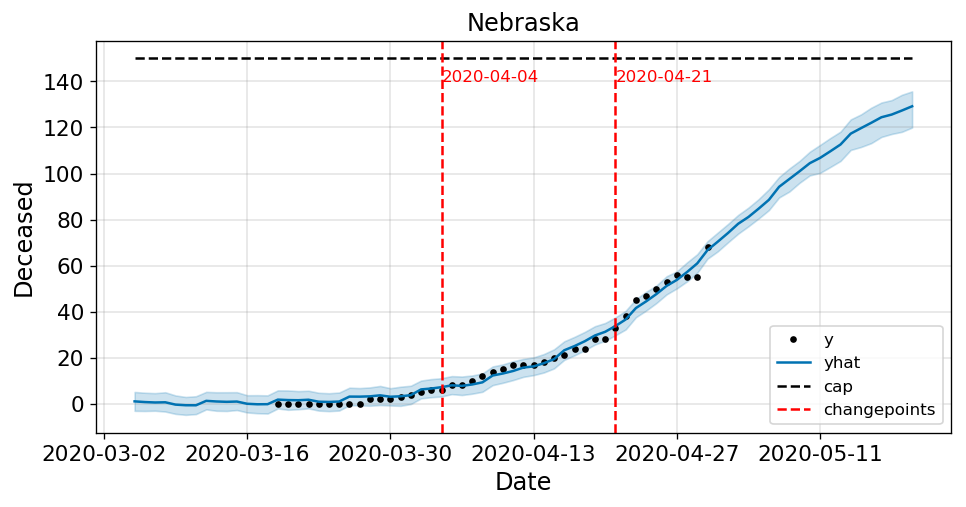

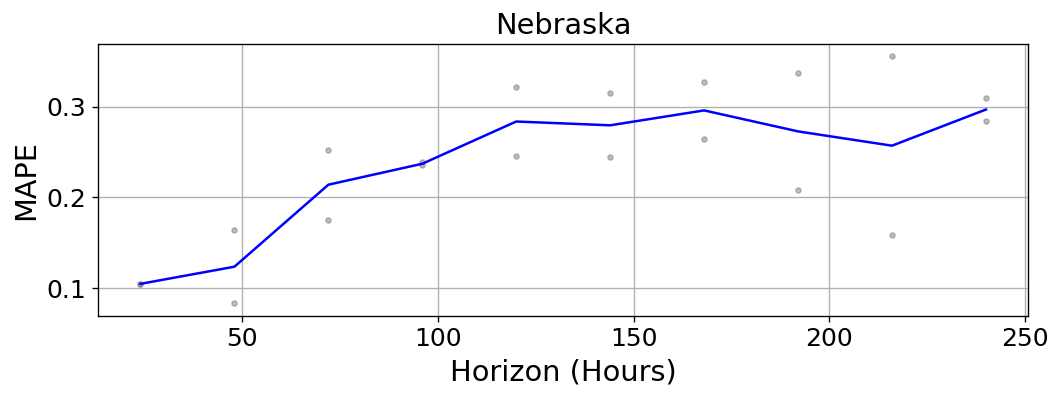

In [146]:
death_data = statedata[::-1].reset_index().rename(columns={'date':'ds','death':'y'})
CA_death = death_data[death_data['state']=='NE']

simlog_death = Prophet(growth='logistic',interval_width=0.95,n_changepoints=2,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
     
    changepoint_prior_scale=0.5)

death_train=CA_death
death_train['cap'] = 150
simlog_death.fit(death_train)
future_death = simlog_death.make_future_dataframe(periods=20)
future_death['cap'] = 150
forecast_death = simlog_death.predict(future_death)

fig5, ax = plt.subplots(figsize=(8,4),dpi=120)
simlog_death.plot(forecast_death,ax=ax)
ax.set_xlabel('Date',fontsize='x-large')
ax.set_ylabel('Deceased',fontsize='x-large')
ax.tick_params(axis='both', which='major', labelsize=13)
#
#ax.plot(death_data[-10:].ds,death_data[-10:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlog_death, forecast_death,trend=False)
a5[0].set_label('changepoints')
ax.legend()
ax.set_title('Nebraska',fontsize='x-large')
ax.text(x= simlog_death.changepoints.iloc[0], y =140 ,s =simlog_death.changepoints.iloc[0].date(),color='red')#,horizontalalignment='center'
ax.text(x= simlog_death.changepoints.iloc[1], y =140 ,s =simlog_death.changepoints.iloc[1].date(),color='red')

cvresult_simlog = cross_validation(simlog_death, horizon = '10 days',period='2 days')
print(performance_metrics(cvresult_simlog))
fig6, ax2 = plt.subplots(figsize=(10,3),dpi=120)
plot_cross_validation_metric(cvresult_simlog, metric='mape',ax = ax2);
ax2.set_title('Nebraska',fontsize='xx-large')
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlabel('Horizon (Hours)',fontsize='xx-large')
ax2.set_ylabel('MAPE',fontsize='xx-large')

In [145]:
simlog_death.changepoints

11   2020-03-30
22   2020-04-10
33   2020-04-21
Name: ds, dtype: datetime64[ns]

a =  740.2210381954005
b =  0.12269077573366668
c =  107.71967529167462


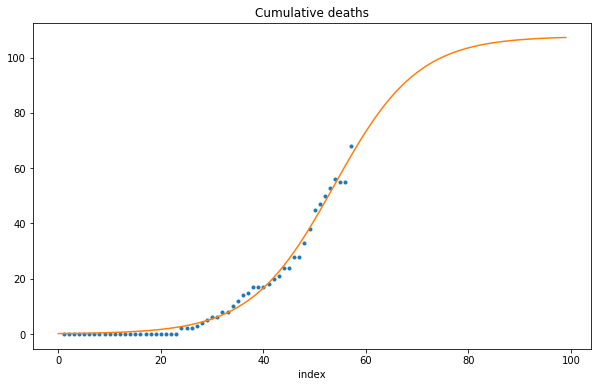

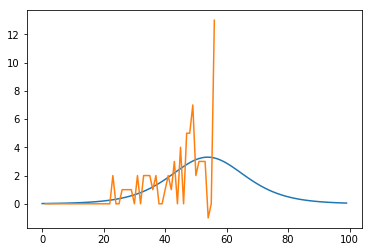

In [560]:
death_data = statedata[::-1].reset_index().rename(columns={'date':'ds','death':'y'})
deaths = death_data[death_data['state']=='NE']

# Randomly initialize the coefficients
p0 = np.random.exponential(size=3)

# Set min bound 0 on all coefficients, and set different max bounds # for each coefficient
bounds = (0, [100000., 1000., 1000000000.])

# Convert pd.Series to np.Array and use Scipy's curve fit to find   # the best Nonlinear Least Squares coefficients
x = np.array(deaths[0:].reset_index().index.values)+1
y = np.nan_to_num(np.array(deaths[0:]['y']))

(a,b,c),cov = curve_fit(func_logistic, 
                              x, y, bounds=bounds, p0=p0, maxfev=1000000)

print('a = ',a)
print('b = ',b)
print('c = ',c)





fig,ax=plt.subplots(figsize=(10,6))

xx=np.arange(100)
ax.plot(x, y,'.')
ax.plot(xx, func_logistic(xx, a, b, c))
ax.set_title('Cumulative deaths')
ax.set_xlabel('index')



def d_logistic(x,a,b,c):
    h = 1e-5
    return (func_logistic(x+h,a,b,c)-func_logistic(x-h,a,b,c))/(2*h)

plt.figure()
plt.plot(xx,d_logistic(xx,a,b,c))
plt.plot(x[:-1],np.diff(y))

Text(0, 0.5, 'Deaths')

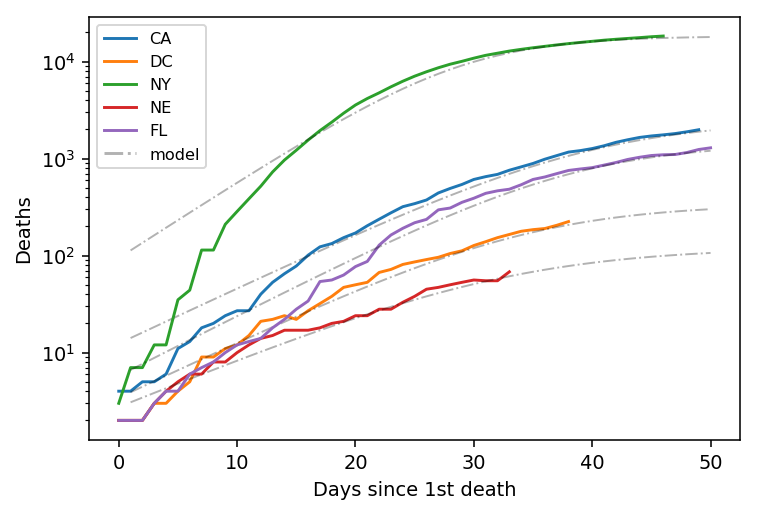

In [30]:
death_data = statedata[::-1].reset_index().rename(columns={'date':'ds','death':'y'})

fig, ax = plt.subplots(dpi=140)

for na in ['CA', 'DC', 'NY', 'NE', 'FL']:
    death = death_data[death_data['state']==na]
    death = death[death.y>1]
    ax.plot(death.reset_index().index.values,death.y,label = na)
    
    x = np.array(death.reset_index().index.values)+1
    y = np.nan_to_num(np.array(death['y']))

    (a,b,c),cov = curve_fit(func_logistic, 
                                  x, y, bounds=bounds, p0=p0, maxfev=1000000)
    
    xx = np.linspace(1,50,50)
    ax.plot(xx, func_logistic(xx, a, b, c),'-.',alpha = 0.3,c='k',lw=1)
    

ax.plot([], [],'-.',alpha = 0.3,c='k',label='model')

ax.set_yscale('log')
#ax.set_xscale('log')
ax.legend(fontsize='small')
ax.set_xlabel('Days since 1st death')
ax.set_ylabel('Deaths')
#ax.grid(axis='y')

In [67]:
ls ..

COVID-19-models.ipynb     china-covid19-data.zip    prophet.png
Covid-19-China.ipynb      coronavirus-in-italy/     sk_c19_new.csv
Covid-19-US.ipynb         coronavirus-in-italy.zip  us_state_c19_new.csv
Covid-19-global .ipynb    coronavirusdataset/       usa_1/
SIR model.ipynb           covid19-in-usa/           weather_c19/
Untitled.ipynb            covid19_data.csv
china-covid19-data/       global1/


In [85]:
temp_ca = pd.read_csv('../weather_c19/avg_temp_humid_ca.csv')
temp_ca['date_time'] = pd.to_datetime(temp_ca['date_time'])

In [70]:
temp_ca.tail()

,date_time,avg_tempC,avg_humidity
177,2020-04-26,26.5,58.5
178,2020-04-27,25.0,59.5
179,2020-04-28,28.0,64.5
180,2020-04-29,25.0,70.0
181,2020-04-30,24.0,67.0


In [83]:
CA_death.ds.iloc[0]

Timestamp('2020-03-05 00:00:00')

In [185]:
#pd.concat([CA_death,temp_ca[temp_ca['date_time']>=CA_death.ds.iloc[0]]],axis=1)

In [ ]:

# def weather_temp(ds):
#     date = (pd.to_datetime(ds)).date()
    
#     return 

# death_data = statedata[::-1].reset_index().rename(columns={'date':'ds','death':'y'})
# CA_death = death_data[death_data['state']=='NE']

# simlog_death = Prophet(growth='logistic',interval_width=0.95,n_changepoints=2,
#     yearly_seasonality=False,
#     weekly_seasonality = True,
#     daily_seasonality = False,
     
#     changepoint_prior_scale=0.5)

# simlog_death.add_regressor('temp')

# death_train=CA_death
# death_train['cap'] = 150
# simlog_death.fit(death_train)
# future_death = simlog_death.make_future_dataframe(periods=20)
# future_death['cap'] = 150
# forecast_death = simlog_death.predict(future_death)


$$
\mathrm{MAPE} = \left(\frac{1}{n} \sum \frac{| \text {Actual-Forecast} |}{| \text {Actual} |}\right)
$$